### Kaykay Essien

Problem: Compute the lifetime value (LTV) of the average buyer - how much they have spent on the platform overall. 
There are many ways to compute this metric, so explain your approach. Compare your metric between a few different 
user segments - for example, users who initially purchased a brand-new item vs. users who initially purchased a used
item. Explain why you think any differences do or do not exist and how you might test these hypotheses.

#### Summary:

1. The Lifetime Value at 50 years was computed to be about USD 6100 per customer, using a BG/NBD methos, as opposed to USD 12000 using a historical cohort method. However, the BG/NBD method was found to be very significantly more accurate than the cohort method.

2. Users who purchased used items first were found to outspend those who purchased brand new items first, by 100% (both sets of users differ from the mean LTV by around 33% on either side). 

3. Similarly, those who purchased fewer new items spent more than those who purchased more new items than average, by 100% as well, with both sets of users differing from the mean LTV by around 33% on either side.

4. When adjusted for outliers, the LTV dropped to USD 1843 for the 89% of users who fell within bounds. Users who purchased used items first, and fewer brand new items still outperformed those who purchased brand new first and more brand new. However, the difference in LTV dropped from 100% to 27% more for those who purchased used products first, and 20% for those who purchased fewer new products.

5. A likelihood ratio test would best verify these hypothesis, but the discrepancies were large enough that one was unnecessary.

## Lifetime Value Calculations

Different methods were considered for estimating Customer Lifetime Value. 

The basic RFM analysis framework was one such method, where customer recency (time since last purchase), frequency(mean purchases over a period of time) and monetary value(mean expenditure per purchase) are used to predict customer lifetime value. However, the drawback with this dataset is that customer behavior is non-contractual, and discontinuous, and extrapolating from RFM was certain to prove calamituous. 

A historical cohort approach was the second considered method. Here, CLV is estimated by trends in customer behaviour over continuous time. However, to avoid the error of making this assumption on individual, non-contractual users, the model is based on the assumption that users from cohorts (i.e, users grouped by time period of birth, or first activity) are likely to have similar behavioral patterns, when viewed as a group.

The final approach considered was the BG/NBD probabilistic model. It is a more robust way of estimating LTV, considering non-contractual, independent users, who may or may not perform a transaction, given a time period. An interesting paper, by some of the proponents of the model is included here : http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import math
import matplotlib.pyplot as plt

## Historical Cohort Model

 

First, users were grouped into cohorts, based on their month of signup, and their transactions were sampled into monthly periods as well. These were used to estimate retention at each period, by cohort; as well as the average expenditure of each cohort at given time periods.

In [2]:
order_sample_df = pd.read_csv("reverb_order_sample.csv")
new_df = order_sample_df.dropna(subset = ['amount_total_cents'])

# define cohort segments
segments = []
month = ['dec-jan', 'jan-feb', 'feb-mar', 'mar-apr', 'apr-may', 'may-jun', 'jun-jul', 'jul-aug', 'aug-sep', 'sep-oct',
         'oct-nov', 'nov-dec']
year = ['2013', '2014', '2015', '2016']
for i in range(len(year)):
    for j in range(len(month)):
        segments.append(month[j]+' '+year[i])

# define cohort segment start dates
date_starts = ['2012-12-10']
year = ['2013', '2014', '2015', '2016']
month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for i in range(len(year)):
    for j in range(len(month)):
        date_starts.append(year[i]+'-'+month[j]+'-10')
date_starts.remove('2016-12-10')

# define cohort segment end dates
date_ends = []
for i in range(len(year)):
    for j in range(len(month)):
        date_ends.append(year[i]+'-'+month[j]+'-10')

# define column names
col_names = []
for i in range(1,49):
    j = str(i)
    col_names.append(j+' months')

In [3]:
# retained_customers function estimates how many customers are 'active' (ie, will make a purchase between 
# the start of the time period till the end of the data's time frame) from a cohort

def retained_customers(df, right, left, term_end):
    valid_users = df.loc[df['registered_at'] < right]
    valid_users = valid_users.loc[valid_users['registered_at'] > left]
    active_segment = valid_users.loc[valid_users['created_at'] > term_end]
    return active_segment['user_id'].unique().shape[0]

## build active customer table by cohort

active_customers_table = pd.DataFrame()
active_customers_table['cohort']= pd.Series(segments)

for i in range(48):
    new_col = []
    for j in range(i,48):
        new_col.append(retained_customers(new_df, date_ends[j-i], date_starts[j-i], date_starts[j]))
    while(len(new_col) < 48):
        new_col.append(None)
    active_customers_table[col_names[i]] = pd.Series(new_col)

    
# expenditure function estimates total purchase values for a cohort over a time period (1 month)

def expenditure(df, right, left, term_end):
    valid_users = df.loc[df['registered_at'] < right]
    valid_users = valid_users.loc[valid_users['registered_at'] > left]
    active_segment = valid_users.loc[valid_users['created_at'] < term_end]
    return active_segment['amount_total_cents'].sum()

## build cumulative expenditure table

cumulative_table = pd.DataFrame()
cumulative_table['cohort']= pd.Series(segments)

for i in range(48):
    new_col = []
    for j in range(i,48):
        new_col.append(expenditure(new_df, date_ends[j-i], date_starts[j-i], date_ends[j]))
    while(len(new_col) < 48):
        new_col.append(None)
    cumulative_table[col_names[i]] = pd.Series(new_col)

       

In [ ]:
## Build Retention Table

retention_table = pd.DataFrame()
retention_table['cohort']= pd.Series(segments)

# get ratio of active users at each time period to users that signed up in that cohort initially
for i in range(48):
    for j in range(i,48):
        if active_customers_table.ix[j-i,col_names[i]] == None:
            retention_table.ix[j-i,col_names[i]] = None
        else:
            retention_table.ix[j-i,col_names[i]] = (active_customers_table.ix[j-i,col_names[i]]
                                                    /active_customers_table.ix[j-i,1])

retention_table.set_index('cohort')

## Build HistoricLTV table
historicLTV = pd.DataFrame()
historicLTV['cohort']= pd.Series(segments)

# LTV at each period estimated as total cumulative purchase value divided by count of initial users in cohort
for i in range(48):
    for j in range(i,48):
        if active_customers_table.ix[j-i,col_names[i]] == None:
            historicLTV.ix[j-i,col_names[i]] = None
        else:
            historicLTV.ix[j-i,col_names[i]] = cumulative_table.ix[j-i,col_names[i]]/active_customers_table.ix[j-i,1]

historicLTV.set_index('cohort')



##### Retention table 

This is a table of users grouped by cohort. At each period (column), the value is the ratio of 'alive' customers,
ie, customers who will make a purchase in the period or in the future, to the initial number of users at the start
of the cohort

In [6]:
retention_table.head()

,cohort,1 months,2 months,3 months,4 months,5 months,6 months,7 months,8 months,9 months,...,39 months,40 months,41 months,42 months,43 months,44 months,45 months,46 months,47 months,48 months
0,dec-jan 2013,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.25
1,jan-feb 2013,1.0,0.923077,0.923077,0.923077,0.923077,0.884615,0.884615,0.884615,0.846154,...,0.461538,0.423077,0.384615,0.307692,0.269231,0.230769,0.192308,0.192308,0.115385,NaN
2,feb-mar 2013,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.469388,0.469388,0.448980,0.448980,0.387755,0.306122,0.265306,0.163265,NaN,NaN
3,mar-apr 2013,1.0,0.863636,0.863636,0.863636,0.863636,0.863636,0.818182,0.818182,0.818182,...,0.272727,0.272727,0.227273,0.136364,0.136364,0.136364,0.136364,NaN,NaN,NaN
4,apr-may 2013,1.0,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,...,0.416667,0.333333,0.333333,0.250000,0.250000,0.166667,NaN,NaN,NaN,NaN


##### Cumulative Average Transaction table or Historic LTV

This is a table of users grouped by cohort. At each period (column), the value is the cumulative average expenditure 
of the users in that cohort.

In [7]:
historicLTV.head()

,cohort,1 months,2 months,3 months,4 months,5 months,6 months,7 months,8 months,9 months,...,39 months,40 months,41 months,42 months,43 months,44 months,45 months,46 months,47 months,48 months
0,dec-jan 2013,0.000000,0.000000,0.000000,9473.750000,10273.750000,35648.750000,37397.500000,37397.500000,37897.500000,...,51346.000000,51346.000000,51346.000000,51346.000000,51346.000000,51346.000000,51346.000000,51346.000000,51346.000000,57596.0
1,jan-feb 2013,11576.923077,11576.923077,11846.153846,12807.692308,13134.615385,13134.615385,13134.615385,15057.692308,15057.692308,...,115503.538462,117666.615385,122296.230769,124686.576923,127086.576923,129286.576923,129795.038462,131410.423077,135862.346154,NaN
2,feb-mar 2013,193.877551,193.877551,2540.816327,2561.224490,2561.224490,5671.428571,5671.428571,8914.285714,10342.857143,...,58054.591837,61159.163265,65220.285714,68337.571429,72340.102041,73307.897959,83922.469388,92463.448980,NaN,NaN
3,mar-apr 2013,4204.545455,4363.636364,4363.636364,4363.636364,4363.636364,6518.181818,6518.181818,6518.181818,6518.181818,...,103378.681818,109347.454545,116036.636364,116036.636364,119059.181818,120981.363636,127704.090909,NaN,NaN,NaN
4,apr-may 2013,14535.000000,15617.916667,15617.916667,16309.166667,16309.166667,16309.166667,16309.166667,19675.333333,28083.666667,...,248986.916667,248986.916667,249611.916667,278986.916667,284195.250000,297619.833333,NaN,NaN,NaN,NaN


From the cumulative table, trends can be observed in the growth of lifetime value over time

In [8]:
## Estimating Lifetime Value - build Lifetimes table

Lifetime_Value_Table = pd.DataFrame()
Lifetime_Value_Table['Customer Age'] = pd.Series(col_names).values

## calculate change in historic LTV from period to period, averaged over all cohorts

new_col = []
for i in range(1,len(col_names)):
    diffs = []
    for j in range(i,len(col_names)):
        a = (historicLTV.ix[j-i,col_names[i]])
        b = (historicLTV.ix[j-i,col_names[i-1]])
        if b != 0:
            diffs.append((a-b)/b)
    new_col.append((sum(diffs)/len(diffs))*100)
while(len(new_col)<48):
    new_col.append(None)
df_col = pd.Series(new_col)
Lifetime_Value_Table['Historic LTV Change %']=df_col.values

Lifetime_Value_Table.set_index('Customer Age')

## explore log-linear relationship between time and LTV change

new_col = []
for i in range(Lifetime_Value_Table['Historic LTV Change %'].dropna().shape[0]):
    new_col.append(np.log10(Lifetime_Value_Table.ix[i,'Historic LTV Change %']))
while(len(new_col)<48):
    new_col.append(None)
df_col = pd.Series(new_col)
Lifetime_Value_Table['Log of Change']=df_col.values


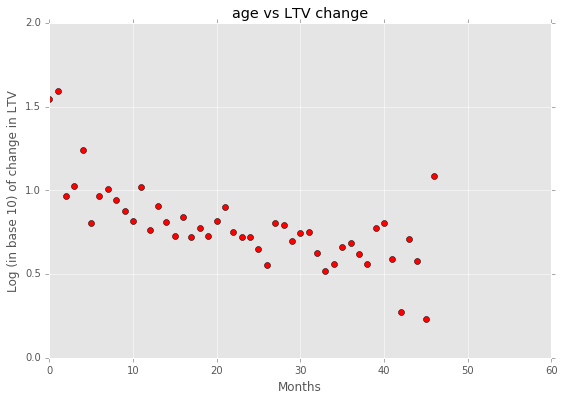

In [91]:
x=[]
for i in range(0, Lifetime_Value_Table['Historic LTV Change %'].dropna().shape[0]):
    x.append(i)
y = (Lifetime_Value_Table['Log of Change'].dropna()).values.tolist()

### figure
% matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.plot(x, y, 'ro')
plt.axis([0, 60, 0, 2])
plt.xlabel('Months')
plt.ylabel('Log (in base 10) of change in LTV')
plt.title('age vs LTV change')
plt.show()

From the figure above, a log-linear cluster of data points can be eyeballed easily. It follows to fit a regression
equation to this scatter, which will be our model. 

In [15]:
from pylab import *
coefficients1 = polyfit(x,y,1)
print('log(LTV Change) = '+str(coefficients1[0])+' months '+'+ '+str(coefficients1[1]))

log(LTV Change) = -0.0125373177202 months + 1.08105836928


From this, we can make predictions with our model, and compare them with historic LTV before predicting future LTV

In [16]:
ages = []
stop = 87
for i in range(1,stop):
    a = str(i)
    b = a+' months'
    ages.append(b)

## Initialise table

clv_model_table = pd.DataFrame()
clv_model_table['customer age'] = pd.Series(ages).values

new_col = []
for i in range(1,stop):
    new_col.append((coefficients1[0]*(i)) + coefficients1[1])
df_col = pd.Series(new_col)
clv_model_table['Log of Change']=df_col.values

new_col = []
for i in range(86):
    new_col.append((10**(clv_model_table.ix[i,'Log of Change']))/100)
df_col = pd.Series(new_col)
clv_model_table['LTV Growth Factor']=df_col.values

for i in range(48):
    model_col = [historicLTV.ix[i,'1 months']]
    hist_col = []
    for k in range(48):
        hist_col.append(historicLTV.ix[i,col_names[k]])
    while (len(hist_col) < 86):
        hist_col.append(None)
    for j in range(1,86):
        model_col.append((model_col[j-1]*clv_model_table.ix[j-1,'LTV Growth Factor']) + model_col[j-1])
    clv_model_table['historical '+segments[i]] = pd.Series(hist_col).values
    clv_model_table['predicted '+segments[i]] = pd.Series(model_col).values



1027444.55252


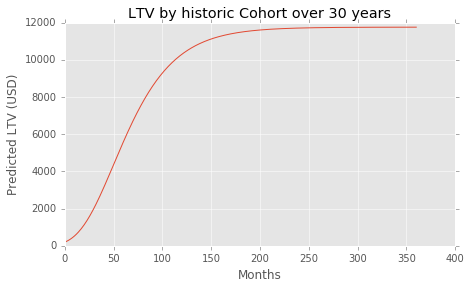

In [92]:
LTVs = []
for i in range(48):
    LTVs.append(clv_model_table.ix[85,'predicted '+segments[i]])

Users = []
for i in range(48):
    Users.append(active_customers_table.ix[i,'1 months'])

calc_table = []
for i in range(48):
    calc_table.append(LTVs[i]*Users[i])

Historic_Cohort_LTV = sum(calc_table)/sum(Users)
print(Historic_Cohort_LTV)

% matplotlib inline
plt.style.use('ggplot')

## plot CLV
plt.figure(figsize=(7, 4))
x_ax = [1]
y_ax = [(historicLTV['1 months'].sum()/historicLTV['1 months'].shape[0])/100]
for i in range(1,360):
    log_change = (coefficients1[0] * i) + coefficients1[1]
    change = (10**(log_change))/100
    new = y_ax[i-1]+(y_ax[i-1]*change)
    y_ax.append(new)
    x_ax.append(i+1)


plt.plot(x_ax,y_ax)
plt.xlabel('Months')
plt.ylabel('Predicted LTV (USD)')
plt.title('LTV by historic Cohort over 30 years')
plt.show()

The trend here shows LTV becoming asymptotic past the 150 month mark. We can take the asymptote ($12,000) as our 
estimate for lifetime value

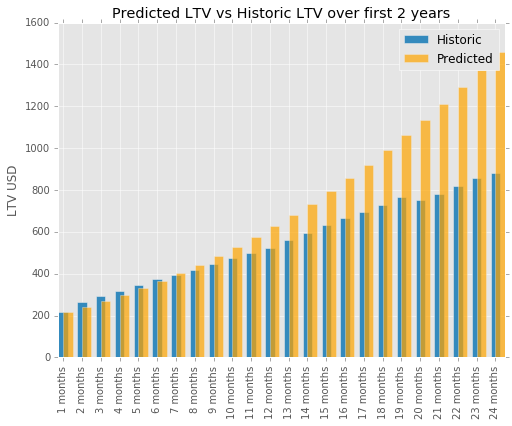

In [138]:
## plot trends
% matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8,6))

y_real = []
y_pred = []
x_lab = []
labels = []
z = []
for i in range(24):
    y_pred.append(y_ax[i])
    y_real.append((historicLTV[str(i+1)+' months'].sum()/(48-i))/100)
    labels.append(col_names[i])
    x_lab.append(i+1)
    z.append(i + 1.25)
labels = tuple(labels) 
groups = 24

width = 0.5


plt.ylabel('LTV USD')
plt.title('Predicted LTV vs Historic LTV over first 2 years')

ax.set_xticks(z)
ax.set_xticklabels(labels, rotation='vertical')


rects1 = ax.bar(x_lab, y_real, width)
rects2 = ax.bar(z, y_pred, width, alpha = 0.7, color='orange')


plt.legend( (rects1[0], rects2[0]), ('Historic', 'Predicted') )

plt.show()

However, from the trend above, the discrepancy between predicted LTV and historic LTV grows as a function of time. This is sufficient enough by the 24th month mark, that it is unnecessary to perform a statistical test to conclude that the model might be wildly problematic.

## BG/NBD Model

While it would have been tedious to build the BG/NBD model from scratch, there is an open-ource library called 'lifetimes' that has the model implemented: https://github.com/CamDavidsonPilon/lifetimes. All that was left to do was to import the model, and engineer features to fit its parameters: 
1. Frequency, or the average number of transactions over a period of time, from a customers first purchase,
2. Recency, or the time since a customer made their last purchase
3. Age, which is the amount of time elapsed since a customer's first purchase.

In [39]:
lifetimes_df = pd.read_csv('grandmaster.csv')

## define frequency column
lifetimes_df['frequency'] = lifetimes_df['total_purchases'] - 1

## define age column
lifetimes_df['T'] = lifetimes_df['age']-lifetimes_df['before_first_purchase']

## define recency column
new_col = [0] * lifetimes_df.shape[0]
lifetimes_df['recency'] = pd.Series(new_col)
for i in range(lifetimes_df.shape[0]):
    if lifetimes_df.ix[i,'frequency'] > 0: 
        lifetimes_df.ix[i,'recency'] = lifetimes_df.ix[i,'T'] - lifetimes_df.ix[i,'since_last_purchase']
        if lifetimes_df.ix[i,'recency'] < 0:
            lifetimes_df.ix[i,'recency'] = 1
## define monetary_value column
lifetimes_df['monetary_value'] = lifetimes_df['expenditure_per_transaction']



In [ ]:
from lifetimes import *
proba_fit = BetaGeoFitter(penalizer_coef=0.0)
proba_fit.fit(lifetimes_df['frequency'], lifetimes_df['recency'], lifetimes_df['T'])
print(proba_fit)

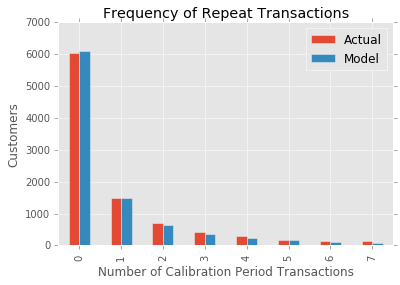

In [41]:
% matplotlib inline
plt.style.use('ggplot')

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(proba_fit)

From fitting the model to our data, and comparing its predictions for number of transactions for each user to that of our historical data, it is clear from eyeballing the graph above, that our model fits very well with our data, and therefore, we can be more confident about predictions with this model, than with the historic CLV model.

However, calculating CLV with the BG/NBD model is dependent on there being no correletion between monetary value (the averange expenditure per transaction for each customer), and the customer's frequency of activity.

In [42]:
lifetimes_df[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,-0.017415
frequency,-0.017415,1.000000


As it is observed that the correlation is quite low, we can proceed with our modelling.

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(lifetimes_df['frequency'],
        lifetimes_df['monetary_value'])
print(ggf)

In [ ]:
lifetimes_df['predicted_CLV'] = ggf.customer_lifetime_value(
    proba_fit, #the model to use to predict the number of future transactions
    lifetimes_df['frequency'],
    lifetimes_df['recency'],
    lifetimes_df['T'],
    lifetimes_df['monetary_value'],
    time=600, # months
    discount_rate=0 # monthly discount rate ~ 12.7% annually
)/100

In [105]:
# LTV With Outliers
CLV = []
for i in range(1,6):
    a = ggf.customer_lifetime_value(
        proba_fit, #the model to use to predict the number of future transactions
        lifetimes_df['frequency'],
        lifetimes_df['recency'],
        lifetimes_df['T'],
        lifetimes_df['monetary_value'],
        time=i*120, # months
        discount_rate=0 # monthly discount rate ~ 12.7% annually
        ).sum()/(lifetimes_df.shape[0] * 100)
    CLV.append(a)
    
print('CLV after 10 years is: '+str(CLV[0]))
print('CLV after 20 years is: '+str(CLV[1]))
print('CLV after 30 years is: '+str(CLV[2]))
print('CLV after 40 years is: '+str(CLV[3]))
print('CLV after 50 years is: '+str(CLV[4]))
lifetimes_df['predicted_CLV'].describe()

CLV after 10 years is: 2133.5645135125865
CLV after 20 years is: 3406.3835561090327
CLV after 30 years is: 4428.297706343537
CLV after 40 years is: 5311.542587729351
CLV after 50 years is: 6103.014532779424


count    9.986000e+03
mean     6.111571e+03
std      3.646651e+04
min      3.679991e-16
25%      6.517103e+02
50%      1.171898e+03
75%      3.707485e+03
max      3.011707e+06
Name: predicted_CLV, dtype: float64

#### Lifetime Value: 

From summary statistics, it shows that the data is wildly skewed! While the average CLV at 50 years (which is where the cut-off was determined) is ~ $6100, only a sixth of users have an LTV more than the average. 

A decision was made to perform further analysis over 2 datasets- one with outliers, and the other with outliers removed by the IQR rule. However, I went with 2 * IQR (Inter-quartile-range) for performing cleaning, as this retains ~ 89 percent of our sample size.

proportion not in outliers: 0.8856


count    8.856000e+03
mean     1.843217e+03
std      1.988091e+03
min      3.679991e-16
25%      5.935361e+02
50%      9.922984e+02
75%      2.231121e+03
max      9.814592e+03
Name: predicted_CLV, dtype: float64

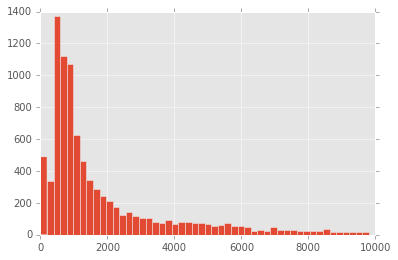

In [87]:
## LTV without outliers, proportions compared , distribution

df = pd.DataFrame()
IQR = lifetimes_df['predicted_CLV'].quantile(0.75) - lifetimes_df['predicted_CLV'].quantile(0.25)
Q1 = lifetimes_df['predicted_CLV'].quantile(0.25) - (2 * IQR)
Q2 = lifetimes_df['predicted_CLV'].quantile(0.75) + (2 * IQR)
df = lifetimes_df.loc[lifetimes_df['predicted_CLV'] <= Q2]
df = df.loc[df['predicted_CLV'] >= Q1]
print('proportion not in outliers: '+(str(df.shape[0]/lifetimes_df.shape[0])))
df['predicted_CLV'].describe()


% matplotlib inline
plt.style.use('ggplot')

df['predicted_CLV'].hist(bins = 50)

df['predicted_CLV'].describe()

Without Outliers, the LTV at 50 years drops to $1,843 per user, and lies below the third quartile mark, making for a less tailed distribution. Plotting with the more evenly distributed dataset shows that we have a gamma distribution. As such, a likelihood ratio test will be best suited for confirming hypothesis, where there is uncertainty.

### Hypothesis: How does customer behaviour affect LTV?

In [119]:
## BrandNew vs UsedFirst

brand_new = lifetimes_df.loc[lifetimes_df['first_type'] == 1] 
used = lifetimes_df.loc[lifetimes_df['first_type'] == 0] 
brandnew = [brand_new['predicted_CLV'].shape[0], brand_new['predicted_CLV'].quantile(0.25), 
            brand_new['predicted_CLV'].median(), brand_new['predicted_CLV'].quantile(0.75), 
            brand_new['predicted_CLV'].mean() ]
useds = [used['predicted_CLV'].shape[0], used['predicted_CLV'].quantile(0.25), used['predicted_CLV'].median(),
        used['predicted_CLV'].quantile(0.75), used['predicted_CLV'].mean()]
full = [lifetimes_df['predicted_CLV'].shape[0], lifetimes_df['predicted_CLV'].quantile(0.25), 
       lifetimes_df['predicted_CLV'].median(), lifetimes_df['predicted_CLV'].quantile(0.75), lifetimes_df['predicted_CLV'].mean()]

brand_new_2 = df.loc[df['first_type'] == 1] 
used_2 = df.loc[df['first_type'] == 0] 
brandnew2 = [brand_new_2['predicted_CLV'].shape[0], brand_new_2['predicted_CLV'].quantile(0.25), 
            brand_new_2['predicted_CLV'].median(), brand_new_2['predicted_CLV'].quantile(0.75), 
            brand_new_2['predicted_CLV'].mean()]
useds2 = [used_2['predicted_CLV'].shape[0], used_2['predicted_CLV'].quantile(0.25), used_2['predicted_CLV'].median(),
        used_2['predicted_CLV'].quantile(0.75), used_2['predicted_CLV'].mean()]
full2 = [df['predicted_CLV'].shape[0], df['predicted_CLV'].quantile(0.25), 
       df['predicted_CLV'].median(), df['predicted_CLV'].quantile(0.75), df['predicted_CLV'].mean()]


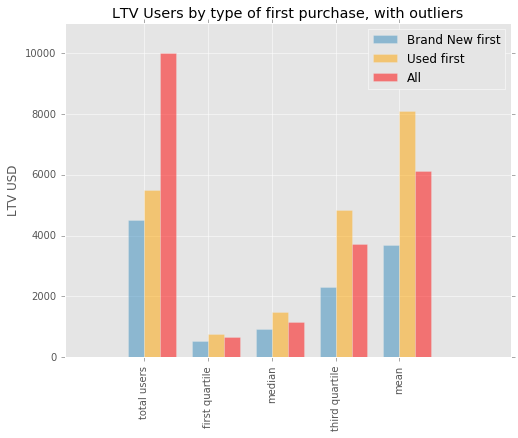

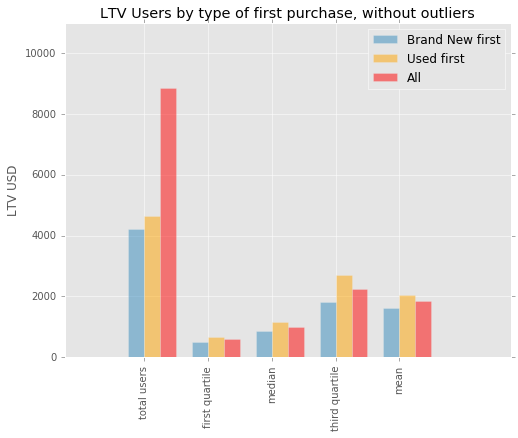

In [135]:
% matplotlib inline
plt.style.use('ggplot')

## plot vars
width = 0.25
x_lab = []
y = []
z = []
for i in range(5):
    x_lab.append(i+1)
    y.append(x_lab[i]+width)
    z.append(y[i]+width)
labels = ('total users','first quartile','median','third quartile','mean')


## With Outliers
fig, ax = plt.subplots(figsize=(8,6))
plt.ylabel('LTV USD')
plt.title('LTV Users by type of first purchase, with outliers')

ax.set_xticks(y)
ax.set_xticklabels(labels, rotation='vertical')

rects1 = ax.bar(x_lab, brandnew, width, alpha=0.5)
rects2 = ax.bar(y, useds, width, alpha=0.5, color='orange')
rects3 = ax.bar(z, full, width, alpha=0.5, color = 'red')


plt.legend( (rects1[0], rects2[0], rects3[0]), ('Brand New first', 'Used first', 'All') )
plt.axis([0, 7, 0, 11000])
plt.show()

## without outliers
fig, ax = plt.subplots(figsize=(8,6))
plt.ylabel('LTV USD')
plt.title('LTV Users by type of first purchase, without outliers')

ax.set_xticks(y)
ax.set_xticklabels(labels, rotation='vertical')

rects1 = ax.bar(x_lab, brandnew2, width, alpha=0.5)
rects2 = ax.bar(y, useds2, width, alpha=0.5, color='orange')
rects3 = ax.bar(z, full2, width, alpha=0.5, color = 'red')


plt.legend( (rects1[0], rects2[0], rects3[0]), ('Brand New first', 'Used first', 'All') )
plt.axis([0, 7, 0, 11000])
plt.show()

##### With Outliers:
Of the 10,000 users in the sample with outliers, roughly 4500 bought a new item first, and 5500 a used one first. However, while their means vary, being slightly greater than USD 8000 for Used first, and below USD 4000 for new first (about 33 percent greater, or less than the true mean, respectively), there isn't as much discrepancy up till the median. This can be attributed to the shape of a gamma distribution, and the large influence of outliers.

##### Without Outliers:
In the cleaned set, there are 8856 users, with 4200 buying a brand new instrument first, and 4656 a used one first, a less than 10 percent difference, as opposed to the 17 percent difference in the set with outliers. However, the mean LTV of the users who purchased used items first is 12.5% more than the sample mean, and it is 11.5% less for those who bought brandnew items first. The discrepancies grow as quartiles are increased, with the used-item users having progressively higher LTVs, and the brand new item users having lower LTVs.

From these, although a likelihood ratio test would ideally be administered to verify the hypothesis, the conclusion should verify the hypothesis that customers who purchase used items first generally outspent those who purchase brand new items first. 

In [141]:
## BrandNew vs UsedFirst
lifetimes_df['prop_new'] = lifetimes_df['brand_new_transactions']/lifetimes_df['total_purchases']
h = lifetimes_df['prop_new'].mean()

high = lifetimes_df.loc[lifetimes_df['prop_new'] >= h] 
low = lifetimes_df.loc[lifetimes_df['prop_new'] <= h] 
 
brandnew = [high['predicted_CLV'].shape[0], high['predicted_CLV'].quantile(0.25), 
            high['predicted_CLV'].median(), high['predicted_CLV'].quantile(0.75), 
            high['predicted_CLV'].mean() ]
useds = [low['predicted_CLV'].shape[0], low['predicted_CLV'].quantile(0.25), low['predicted_CLV'].median(),
        low['predicted_CLV'].quantile(0.75), low['predicted_CLV'].mean()]
full = [lifetimes_df['predicted_CLV'].shape[0], lifetimes_df['predicted_CLV'].quantile(0.25), 
       lifetimes_df['predicted_CLV'].median(), lifetimes_df['predicted_CLV'].quantile(0.75), 
        lifetimes_df['predicted_CLV'].mean()]

df['prop_new'] = df['brand_new_transactions']/df['total_purchases']
h = df['prop_new'].mean()

high2 = df.loc[df['prop_new'] >= h] 
low2 = df.loc[df['prop_new'] <= h] 
 
brandnew2 = [high2['predicted_CLV'].shape[0], high2['predicted_CLV'].quantile(0.25), 
            high2['predicted_CLV'].median(), high2['predicted_CLV'].quantile(0.75), 
            high2['predicted_CLV'].mean() ]
used2 = [low2['predicted_CLV'].shape[0], low2['predicted_CLV'].quantile(0.25), low2['predicted_CLV'].median(),
        low2['predicted_CLV'].quantile(0.75), low2['predicted_CLV'].mean()]
full2 = [df['predicted_CLV'].shape[0], df['predicted_CLV'].quantile(0.25), 
       df['predicted_CLV'].median(), df['predicted_CLV'].quantile(0.75), df['predicted_CLV'].mean()]

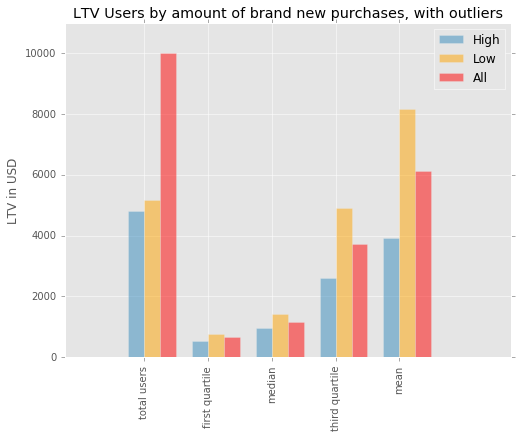

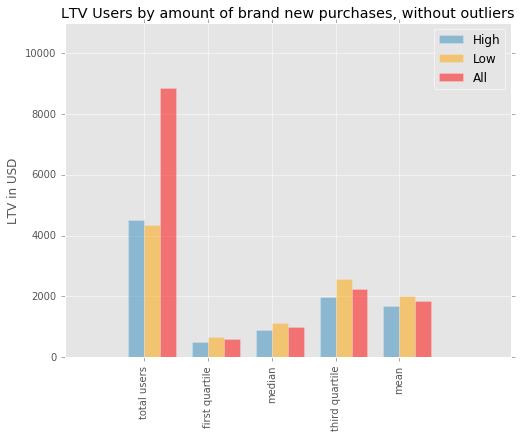

In [143]:
## plot vars
width = 0.25
x_lab = []
y = []
z = []
for i in range(5):
    x_lab.append(i+1)
    y.append(x_lab[i]+width)
    z.append(y[i]+width)
labels = ('total users','first quartile','median','third quartile','mean')


## With Outliers
fig, ax = plt.subplots(figsize=(8,6))
plt.ylabel('LTV in USD')
plt.title('LTV Users by amount of brand new purchases, with outliers')

ax.set_xticks(y)
ax.set_xticklabels(labels, rotation='vertical')

rects1 = ax.bar(x_lab, brandnew, width, alpha=0.5)
rects2 = ax.bar(y, useds, width, alpha=0.5, color='orange')
rects3 = ax.bar(z, full, width, alpha=0.5, color = 'red')


plt.legend( (rects1[0], rects2[0], rects3[0]), ('High', 'Low', 'All') )
plt.axis([0, 7, 0, 11000])
plt.show()

## without outliers
fig, ax = plt.subplots(figsize=(8,6))
plt.ylabel('LTV in USD')
plt.title('LTV Users by amount of brand new purchases, without outliers')

ax.set_xticks(y)
ax.set_xticklabels(labels, rotation='vertical')

rects1 = ax.bar(x_lab, brandnew2, width, alpha=0.5)
rects2 = ax.bar(y, used2, width, alpha=0.5, color='orange')
rects3 = ax.bar(z, full2, width, alpha=0.5, color = 'red')


plt.legend( (rects1[0], rects2[0], rects3[0]), ('High', 'Low', 'All') )
plt.axis([0, 7, 0, 11000])
plt.show()

##### With Outliers
Of the 10000 users, 5178 purchased less brand new items than average, while 4822 purchased more than the average, a difference of 7%. However, the average LTV of customers who purchase less brand new items is 33% more than expected, while that of those who purchase more is 35.8% less than expected, with large discrepancies beginning past the median, and before the 75th quartile.

##### Without Outliers
Without outliers, 4495 users purchased more brand new items, while 4361 purchased less brand new items than average, and interesting switch from data with outliers, but with 3% difference. It is inferred from this that more of the outliers who have higher LTVs purchase used instruments, than brand new instruments, as the difference in means falls to 9.5% more for those who purchase fewer brand new items, and 9.2 less than average for those who purchase more brand new items.